In [ ]:
#!pip install mrcfile opencv-python tqdm

In [1]:
import mrcfile
import numpy as np
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# OpenCV's Farneback algorithm requires 8-bit grayscale images.
def normalize_volume_to_uint8(volume):
    """Normalizes a float32 volume to the 0-255 range and converts to uint8."""
    vol_min = volume.min()
    vol_max = volume.max()
    if vol_max > vol_min:
        normalized = 255 * (volume - vol_min) / (vol_max - vol_min)
    else:
        normalized = np.zeros_like(volume) # Handle flat volume
    return normalized.astype(np.uint8)

In [3]:
even_vol = mrcfile.read("/nas/vruiz/cryoCARE/empiar11415/even.mrc")

In [4]:
odd_vol = mrcfile.read("/nas/vruiz/cryoCARE/empiar11415/odd.mrc")

In [5]:
even_vol_8 = normalize_volume_to_uint8(even_vol)

In [6]:
odd_vol_8 = normalize_volume_to_uint8(odd_vol)

In [7]:
farneback_params = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

In [8]:
projected_vol = np.zeros_like(odd_vol, dtype=np.float32)

### Generamos odd_registered
Usando los slices "odd" generamos un volumen con sus estructuras alineadas con las del volumen "even".

In [9]:
for z in tqdm(range(even_vol.shape[0]), desc="Projecting Slices"):

    # Calculate the dense optical flow from slice_z_plus_1 to slice_z
    flow = cv2.calcOpticalFlowFarneback(even_vol[z, ...], odd_vol[z, ...], None, **farneback_params)
    
    # Create a remapping grid from the flow field
    height, width = flow.shape[:2]
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # The new map tells where each pixel in the output image should come from in the input image
    map_x = (x_coords + flow[..., 0]).astype(np.float32)
    map_y = (y_coords + flow[..., 1]).astype(np.float32)

    # Warp the *original float32 slice* using the map for maximum precision
    original_slice_to_warp = odd_vol[z , ...]
    projected_slice = cv2.remap(
        src=original_slice_to_warp,
        map1=map_x,
        map2=map_y,
        #interpolation=cv2.INTER_LINEAR,
        interpolation=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_REPLICATE # Handle edge pixels
    )
    
    # Store the result
    projected_vol[z, ...] = projected_slice

print("\nOptical flow calculation and projection complete.")

Projecting Slices:   0%|          | 0/33 [00:00<?, ?it/s]


Optical flow calculation and projection complete.


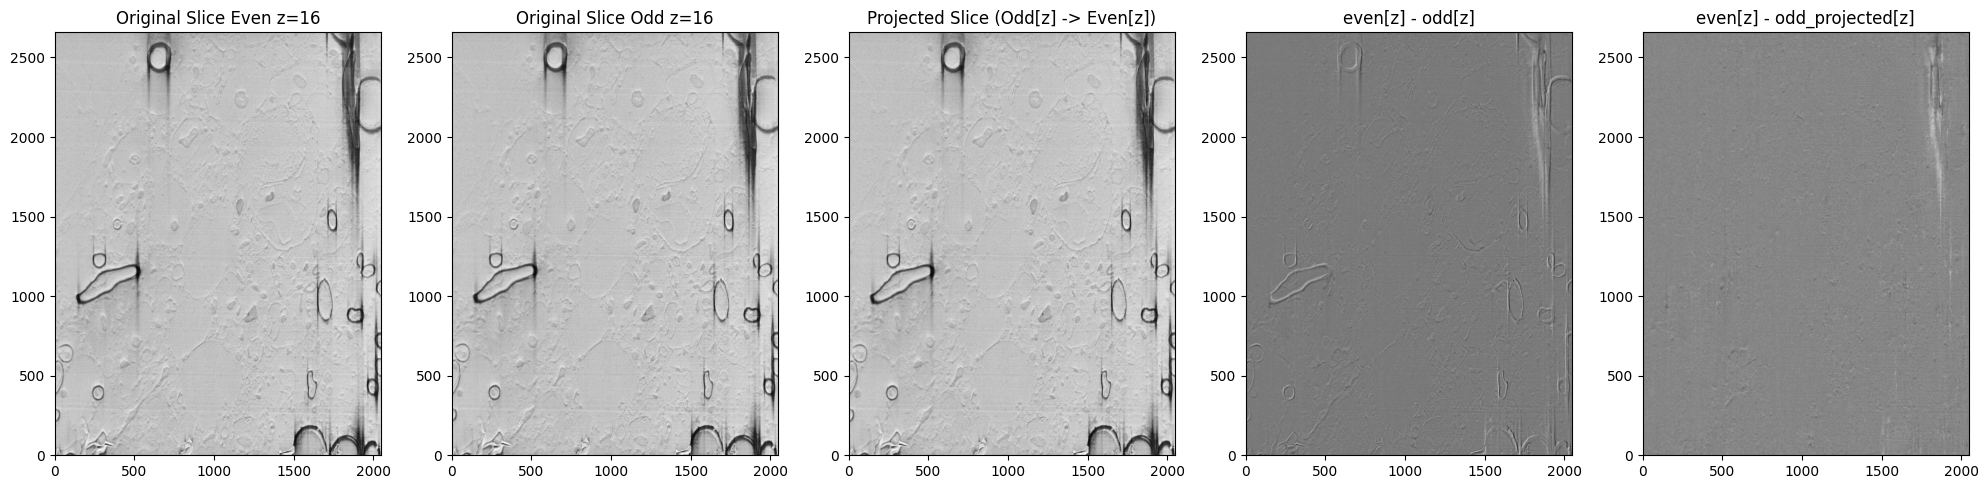

In [10]:
slice_idx = even_vol.shape[0] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

im1 = axes[0].imshow(even_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[0].set_title(f'Original Slice Even z={slice_idx}')
axes[0].grid(False)

im2 = axes[1].imshow(odd_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[1].set_title(f'Original Slice Odd z={slice_idx}')
axes[1].grid(False)

im3 = axes[2].imshow(projected_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[2].set_title(f'Projected Slice (Odd[z] -> Even[z])')
axes[2].grid(False)

im4 = axes[3].imshow(even_vol[slice_idx, ...].T - odd_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[3].set_title(f'even[z] - odd[z]')
axes[3].grid(False)

im4 = axes[4].imshow(even_vol[slice_idx, ...].T - projected_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[4].set_title(f'even[z] - odd_projected[z]')
axes[4].grid(False)

plt.tight_layout()
plt.show()

In [11]:
output_filename = '/nas/vruiz/cryoCARE/empiar11415/odd_registered.mrc'
print("Writing", output_filename)

with mrcfile.new(output_filename, overwrite=True) as mrc:
    mrc.set_data(projected_vol)
    mrc.data

print("done")

Writing /nas/vruiz/cryoCARE/empiar11415/odd_registered.mrc
done


In [12]:
!ls -l /nas/vruiz/cryoCARE/empiar11415/odd_registered.mrc

-rw-r----- 1 jupyter-vruiz jupyter-vruiz 719094784 oct  4 11:16 /nas/vruiz/cryoCARE/empiar11415/odd_registered.mrc


### Generamos even_registered
Usando los slices "even" generamos un volumen con sus estructuras alineadas con las del volumen "odd".

In [13]:
for z in tqdm(range(even_vol.shape[0]), desc="Projecting Slices"):

    # Calculate the dense optical flow from slice_z_plus_1 to slice_z
    flow = cv2.calcOpticalFlowFarneback(odd_vol[z, ...], even_vol[z, ...], None, **farneback_params)
    
    # Create a remapping grid from the flow field
    height, width = flow.shape[:2]
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    
    # The new map tells where each pixel in the output image should come from in the input image
    map_x = (x_coords + flow[..., 0]).astype(np.float32)
    map_y = (y_coords + flow[..., 1]).astype(np.float32)

    # Warp the *original float32 slice* using the map for maximum precision
    original_slice_to_warp = even_vol[z , ...]
    projected_slice = cv2.remap(
        src=original_slice_to_warp,
        map1=map_x,
        map2=map_y,
        #interpolation=cv2.INTER_LINEAR,
        interpolation=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_REPLICATE # Handle edge pixels
    )
    
    # Store the result
    projected_vol[z, ...] = projected_slice

print("\nOptical flow calculation and projection complete.")

Projecting Slices:   0%|          | 0/33 [00:00<?, ?it/s]


Optical flow calculation and projection complete.


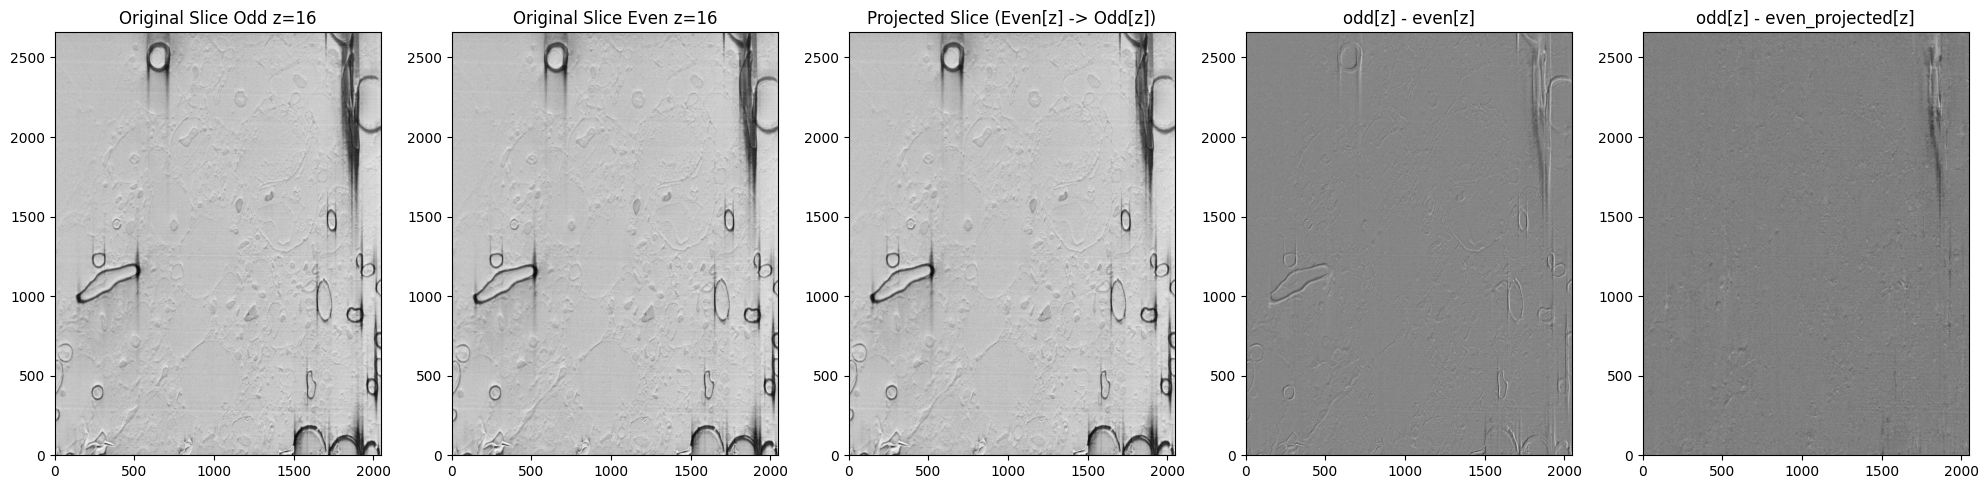

In [14]:
slice_idx = even_vol.shape[0] // 2

fig, axes = plt.subplots(1, 5, figsize=(20, 20))

im1 = axes[0].imshow(odd_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[0].set_title(f'Original Slice Odd z={slice_idx}')
axes[0].grid(False)

im2 = axes[1].imshow(even_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[1].set_title(f'Original Slice Even z={slice_idx}')
axes[1].grid(False)

im3 = axes[2].imshow(projected_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[2].set_title(f'Projected Slice (Even[z] -> Odd[z])')
axes[2].grid(False)

im4 = axes[3].imshow(odd_vol[slice_idx, ...].T - even_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[3].set_title(f'odd[z] - even[z]')
axes[3].grid(False)

im4 = axes[4].imshow(odd_vol[slice_idx, ...].T - projected_vol[slice_idx, ...].T, cmap='gray', origin='lower')
axes[4].set_title(f'odd[z] - even_projected[z]')
axes[4].grid(False)

plt.tight_layout()
plt.show()

In [15]:
output_filename = '/nas/vruiz/cryoCARE/empiar11415/even_registered.mrc'
print("Writing", output_filename)

with mrcfile.new(output_filename, overwrite=True) as mrc:
    mrc.set_data(projected_vol)
    mrc.data

print("done")

Writing /nas/vruiz/cryoCARE/empiar11415/even_registered.mrc
done


In [16]:
!ls -l /nas/vruiz/cryoCARE/empiar11415/even_registered.mrc

-rw-r----- 1 jupyter-vruiz jupyter-vruiz 719094784 oct  4 11:17 /nas/vruiz/cryoCARE/empiar11415/even_registered.mrc
